In [30]:
import pandas as pd
import numpy as np
import os
#import src.data_loader as data_loader
#from src.utils import copy_values, map_to_rating_values

# ADD PATH TO PLAYLIST FOLDER HERE
folder_path = '../playlists'

In [31]:
# Makes Artists Frequency per Playlist dataframe from folder_path
def make_matrix():
    # Initialize a DataFrame for the final output
    final_df = pd.DataFrame()

    # Set for storing unique artist names
    all_artists = set()

    # List all CSV files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            playlist_df = pd.read_csv(file_path)
            playlist_name = os.path.splitext(filename)[0]
            artist_count = {}

            for _, row in playlist_df.iterrows():
                # Extract and process artists
                artists = [artist.strip() for artist in row['Artist Name(s)'].split(',')]
                for artist in artists:
                    all_artists.add(artist)
                    artist_count[artist] = artist_count.get(artist, 0) + 1

            # Create a DataFrame for the current playlist
            playlist_artist_df = pd.DataFrame([{'Playlist Name': playlist_name, **artist_count}])
            final_df = pd.concat([final_df, playlist_artist_df], ignore_index=True)

    # Add columns for any missing artists in each playlist
    missing_artists = all_artists - set(final_df.columns)
    for artist in missing_artists:
        final_df[artist] = 0

    return final_df

df = make_matrix()
original_df = df #saved for columns later
df.to_csv("raw_artists.csv", index=False)

df = df.apply(pd.to_numeric, errors='coerce')
df = np.array(df)

In [41]:
## ALTERNATING MINIMIZATION FUNCTIONS

def solve_V(X, U):
    """
    Given matrix X of shape (n, m),  U of shape (n, k), returns V of shape (m, k) such that X = U * transpose(V)
    :param X:
    :param U:
    :return:
    """
    n, m = X.shape
    k = U.shape[1]
    V = np.zeros((m, k))
    for i in range(m):
        column = X[:, i].flatten()
        indexes = np.argwhere(~np.isnan(column)).flatten()
        U_omega = U[indexes, :]
        y_omega = X[indexes, i]
        V[i, :] = np.linalg.lstsq(U_omega, y_omega)[0]
    return V


def alt_min(X, U_0, T):
    """
    Given X, initial values of U and number of iterations T, returns U, V such that X = U * transpose(V)
    :param X:
    :param U_0:
    :param T:
    :return:
    """
    U = U_0
    for _ in range(T):
        V = solve_V(X, U)
        U = solve_V(np.transpose(X), V)
    return U, V


def matrix_completion(X, T, k):
    """
    Given a matrix X with missing values, fills missing values in X
    :param X:
    :param T:
    :param k:
    :return:
    """
    X_hat = np.nan_to_num(X)
    U, e, V_t = np.linalg.svd(X_hat, full_matrices=True)
    U, V = alt_min(X, U[:, :k], T)
    X_filled = np.matmul(U, np.transpose(V))
    return X_filled

new_df = matrix_completion(df, 10, 200)
new_df = pd.DataFrame(new_df)
new_df.columns = original_df.columns
new_df.index = original_df['Playlist Name']
new_df.to_csv("complete_artists.csv", index=True)

/var/folders/_d/bgc0ml897834kf4fkff32r300000gn/T/ipykernel_10308/4206828989.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  V[i, :] = np.linalg.lstsq(U_omega, y_omega)[0]


In [45]:
## RECOMMEND
## THERE IS A BUG HERE---> WHY IS PLAYLIST NAME EVERYWHERE SOS
max_values_by_row = new_df.max(axis=1)
print("Maximum values by row:")
print(max_values_by_row)

max_values_columns = new_df.idxmax(axis=1)
print("\nColumn names with maximum values:")
print(max_values_columns)


print("\nMaximum values by row and their corresponding columns:")
for index, (value, column) in enumerate(zip(max_values_by_row, max_values_columns)):
    print(f"Row {index}: Max Value = {value}, Column = {column}")

Maximum values by row:
Playlist Name
puerto_rico                            45.000000
current                               553.850696
istanbul_collab_take_2                  2.000000
night_drives                            5.000000
t_time                                 22.000000
rachel_liu_was_my_roommate              9.000000
i78                                     7.000000
farillaga                               6.000000
run                                     9.000000
2018                                 2018.000000
i_ran_i_ran_so_far_away                37.158559
chaotic_neutral                        13.000000
quotewall_against_the_patriarchy    26300.356794
cool_cool_cool_tight_tight_tight       58.690985
math_pset                              16.000000
sleep                                   2.000000
main_character                         26.450336
pch_roadtrip_                          12.000000
dtype: float64

Column names with maximum values:
Playlist Name
puerto_rico      

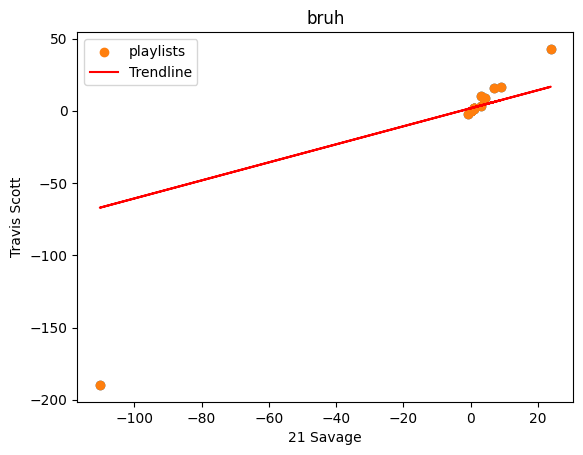

In [53]:
## CORRELATION BETWEEN ARTISTS ACROSS PLAYLISTS
import matplotlib.pyplot as plt
artist1 = '21 Savage'
artist2 = 'Travis Scott'
plt.scatter(new_df[artist1], new_df[artist2])
b, m = np.polyfit(new_df[artist1], new_df[artist2], 1)

plt.scatter(new_df[artist1], new_df[artist2], label='playlists')
plt.plot(new_df[artist1], b + m * new_df[artist1], color='red', label='Trendline')
plt.xlabel(artist1)
plt.ylabel(artist2)
plt.title('bruh')
plt.legend()
plt.show()
